In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import os

from ssl_eeg import preprocessing as pr, preprocessing_nback as prn, preprocessing_unlabeled as pru, model, prediction as prd, metrics, plot

models_doc = pd.read_csv(model.models_doc_path, index_col=0)
models_conf = pd.read_csv(model.models_conf_path, index_col=0)

/home/jeusa/anaconda3/envs/ba/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device is: cuda:0


In [2]:
accurracy_columns = list(models_conf.columns)[-16:]
param_columns = ["supervised", "learning_rate", "epochs", "filter", "test_session", "augmentation_scale"]

rel = models_conf.loc[models_conf["relevant"]==True][param_columns + accurracy_columns]
sl = rel.loc[rel["supervised"]=="supervised"].drop(columns=(["augmentation_scale", "learning_rate"] + [i for i in accurracy_columns if "disjoint" in i]))
ssl = rel.loc[rel["supervised"]=="self-supervised"].drop(columns=["test_session", "mean_val_acc", "std_val_acc", "mean_val_pool_acc", "std_val_pool_acc"])

rel

supervised  learning_rate  epochs  filter  test_session  \
conf_id                                                                 
111      self-supervised          0.100      10      45            -1   
112      self-supervised          0.050      10      45            -1   
113      self-supervised          0.010      10      45            -1   
114           supervised          0.001      15      45             4   
116           supervised          0.001      50      45             4   
117           supervised          0.001      15      55             4   
118           supervised          0.001      15      45             1   
119           supervised          0.001      15      45             2   
120           supervised          0.001      15      45             3   
121           supervised          0.001      50      45             1   
122           supervised          0.001      50      45             2   
123           supervised          0.001      50      45             3   
128      self-supervised          0.100      10      55            -1   
129      self-supervised          0.050      10      55            -1   
130      self-supervised          0.010      10      55            -1   
131           supervised          0.001      15      55             1   
132           supervised          0.001      15      55             2   
133           supervised          0.001      15      55             3   

         augmentation_scale  mean_val_acc  std_val_acc  mean_test_acc  \
conf_id                                                                 
111                       1      0.000000     0.000000       0.229108   
112                       2      0.000000     0.000000       0.241397   
113                       3      0.000000     0.000000       0.240695   
114                       0      0.560748     0.019825       0.267556   
116                       0      0.584112     0.019825       0.246489   
117                       0      0.785047     0.000000       0.250000   
118                       0      0.462617     0.026434       0.337781   
119                       0      0.429907     0.052868       0.320927   
120                       0      0.535047     0.003304       0.286517   
121                       0      0.509346     0.019825       0.320927   
122                       0      0.567757     0.003304       0.322331   
123                       0      0.553738     0.029738       0.284410   
128                       1      0.000000     0.000000       0.247542   
129                       2      0.000000     0.000000       0.251931   
130                       3      0.000000     0.000000       0.249122   
131                       0      0.780374     0.033042       0.252809   
132                       0      0.773364     0.029738       0.250000   
133                       0      0.780374     0.006608       0.188202   

         std_test_acc  ...  mean_triplet_test_acc  std_triplet_test_acc  \
conf_id                ...                                                
111          0.001241  ...               0.964010              0.001241   
112          0.005710  ...               0.928020              0.000497   
113          0.006207  ...               0.831987              0.008193   
114          0.016883  ...               0.513176              0.005549   
116          0.004966  ...               0.522166              0.009230   
117          0.000000  ...               0.593066              0.015851   
118          0.064553  ...               0.610971              0.030961   
119          0.018869  ...               0.539060              0.015840   
120          0.003973  ...               0.539889              0.031634   
121          0.020856  ...               0.604563              0.039439   
122          0.010924  ...               0.544789              0.005594   
123          0.022842  ...               0.548487              0.027667   
128          0.013904  ...               0

### Supervised encoders

In [3]:
sl_45f = sl.loc[sl["filter"]==45]
sl_55f = sl.loc[sl["filter"]==55]
sl_15_45 = sl.loc[(sl["epochs"]==15) & (sl["filter"]==45)]
sl_15_55 = sl.loc[(sl["epochs"]==15) & (sl["filter"]==55)]

In [4]:
sl_metrics = ["triplet_val_acc", "val_acc", "val_mae", "triplet_test_acc", "test_acc", "test_mae"]

print("45Hz:")
print("mean")
display(models_doc.loc[models_doc["conf_id"].isin(sl_15_45.index)][sl_metrics].mean().round(3))
print("std")
display(models_doc.loc[models_doc["conf_id"].isin(sl_15_45.index)][sl_metrics].std().round(3))

print("55Hz:")
print("mean")
display(models_doc.loc[models_doc["conf_id"].isin(sl_15_55.index)][sl_metrics].mean().round(3))
print("std")
display(models_doc.loc[models_doc["conf_id"].isin(sl_15_55.index)][sl_metrics].std().round(3))

45Hz:
mean


triplet_val_acc     0.681
val_acc             0.497
val_mae             0.586
triplet_test_acc    0.551
test_acc            0.303
test_mae            1.128
dtype: float64

std


triplet_val_acc     0.028
val_acc             0.061
val_mae             0.080
triplet_test_acc    0.043
test_acc            0.040
test_mae            0.147
dtype: float64

55Hz:
mean


triplet_val_acc     0.802
val_acc             0.780
val_mae             0.330
triplet_test_acc    0.592
test_acc            0.235
test_mae            1.287
dtype: float64

std


triplet_val_acc     0.025
val_acc             0.018
val_mae             0.073
triplet_test_acc    0.047
test_acc            0.043
test_mae            0.247
dtype: float64

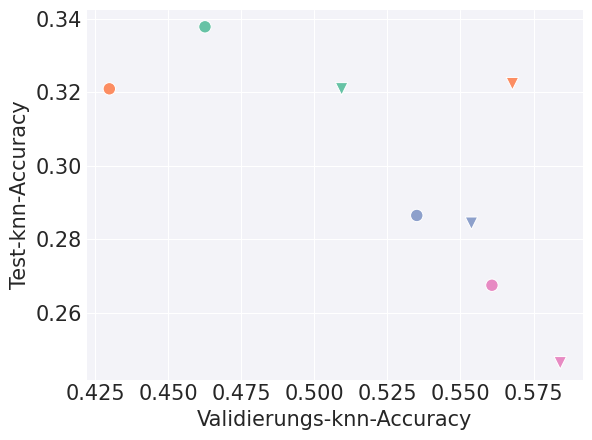

In [5]:
ax = sns.scatterplot(data=sl_45f.rename(columns={"epochs": "Epochen", "test_session": "Testaufnahme"}).loc[sl_45f["epochs"]>=15], x="mean_val_acc", y="mean_test_acc", hue="Testaufnahme", palette=sns.mpl_palette("Set2", 4), style="Epochen", s=80, markers=["o", "v"])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.04, 1))
ax.set(xlabel="Validierungs-knn-Accuracy", ylabel="Test-knn-Accuracy")
plot.save_plot_and_legend(ax, os.path.join(plot.plots_path, "correlation_val_acc_test_acc_sl"))
plt.show()

### Self-supervised Encoders

In [18]:
ssl_45 = ssl.loc[ssl["filter"]==45]
ssl_55 = ssl.loc[ssl["filter"]==55]
ssl_metrics = ["triplet_val_acc", "triplet_test_acc", "test_acc", "test_mae"]
models_ssl_45 = models_doc.loc[models_doc["conf_id"].isin(ssl_45.index)][ssl_metrics]
models_ssl_55 = models_doc.loc[models_doc["conf_id"].isin(ssl_55.index)][ssl_metrics]

print("45Hz:")
for a in range(1, 4):
    print("augmentation scale:", a)
    print("mean")
    display(models_ssl_45.loc[models_doc["conf_id"].isin(ssl_45.loc[ssl_45["augmentation_scale"]==a].index)].mean().round(3))
    print("std")
    display(models_ssl_45.loc[models_doc["conf_id"].isin(ssl_45.loc[ssl_45["augmentation_scale"]==a].index)].std().round(3))

print("55Hz:")
for a in range(1, 4):
    print("augmentation scale:", a)
    print("mean")
    display(models_ssl_55.loc[models_doc["conf_id"].isin(ssl_55.loc[ssl_55["augmentation_scale"]==a].index)].mean().round(3))
    print("std")
    display(models_ssl_55.loc[models_doc["conf_id"].isin(ssl_55.loc[ssl_55["augmentation_scale"]==a].index)].std().round(3))

45Hz:
augmentation scale: 1
mean


triplet_val_acc     0.968
triplet_test_acc    0.964
test_acc            0.229
test_mae            1.277
dtype: float64

std


triplet_val_acc     0.010
triplet_test_acc    0.001
test_acc            0.001
test_mae            0.016
dtype: float64

augmentation scale: 2
mean


triplet_val_acc     0.948
triplet_test_acc    0.928
test_acc            0.241
test_mae            1.255
dtype: float64

std


triplet_val_acc     0.015
triplet_test_acc    0.000
test_acc            0.006
test_mae            0.005
dtype: float64

augmentation scale: 3
mean


triplet_val_acc     0.879
triplet_test_acc    0.832
test_acc            0.241
test_mae            1.282
dtype: float64

std


triplet_val_acc     0.017
triplet_test_acc    0.008
test_acc            0.006
test_mae            0.024
dtype: float64

55Hz:
augmentation scale: 1
mean


triplet_val_acc     0.957
triplet_test_acc    0.814
test_acc            0.248
test_mae            1.245
dtype: float64

std


triplet_val_acc     0.003
triplet_test_acc    0.003
test_acc            0.014
test_mae            0.012
dtype: float64

augmentation scale: 2
mean


triplet_val_acc     0.864
triplet_test_acc    0.676
test_acc            0.252
test_mae            1.215
dtype: float64

std


triplet_val_acc     0.005
triplet_test_acc    0.012
test_acc            0.006
test_mae            0.009
dtype: float64

augmentation scale: 3
mean


triplet_val_acc     0.808
triplet_test_acc    0.599
test_acc            0.249
test_mae            1.232
dtype: float64

std


triplet_val_acc     0.025
triplet_test_acc    0.033
test_acc            0.008
test_mae            0.006
dtype: float64

### Accuracies depending on margin

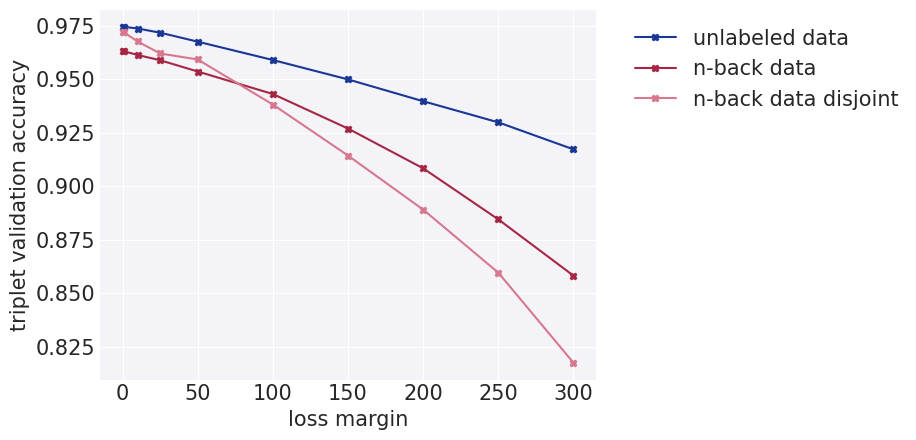

In [19]:
id = 111
fig = plot.plot_margin_accuracies_ssl(id, data="n-back", val_ses=3)

### Accuracy history

Loading loss of conf_id_111_model_1_ssl
Loading loss of conf_id_111_model_3_ssl


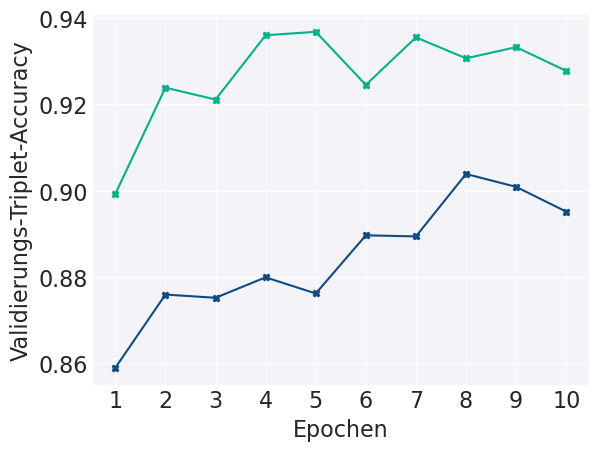

In [6]:
mpl.rcParams["font.size"] = 16
fig = plot.plot_metrics([111], "val_acc", show_legend=False)
fig.savefig(os.path.join(plot.plots_path, "val_acc_conf_id_111_ssl.png"), dpi=200, bbox_inches="tight")

### Losses

Loading loss of conf_id_111_model_1_ssl
Loading loss of conf_id_111_model_3_ssl


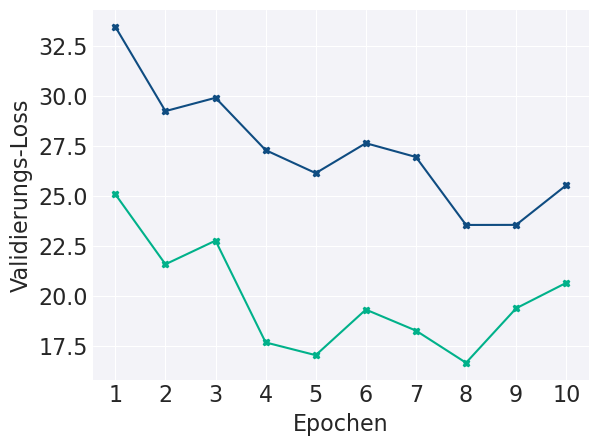

In [5]:
mpl.rcParams["font.size"] = 16
fig = plot.plot_metrics(111, "val_loss", show_legend=False)
fig.savefig(os.path.join(plot.plots_path, "val_loss_conf_id_111_ssl.png"), dpi=200, bbox_inches="tight")

### Confusion Matrix

conf_id_114_model_1 val
0.5747663551401869


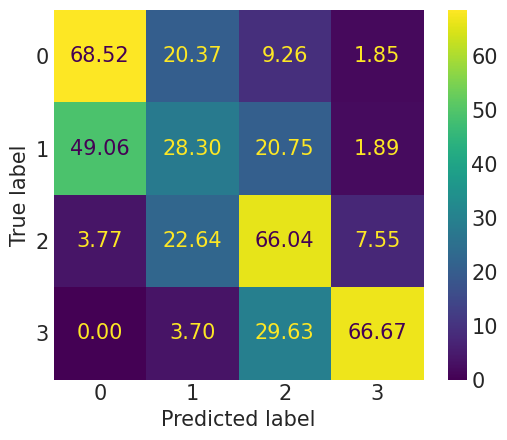

conf_id_114_model_2 val
0.5467289719626168


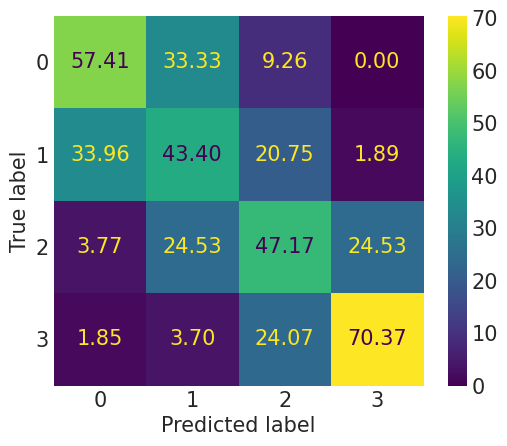

Average Confusion Matrix


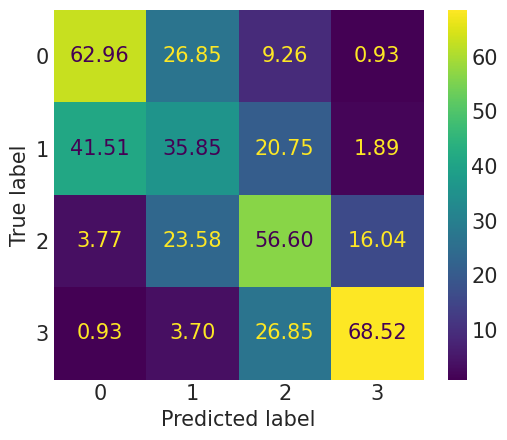

conf_id_114_model_1 test
0.2794943820224719


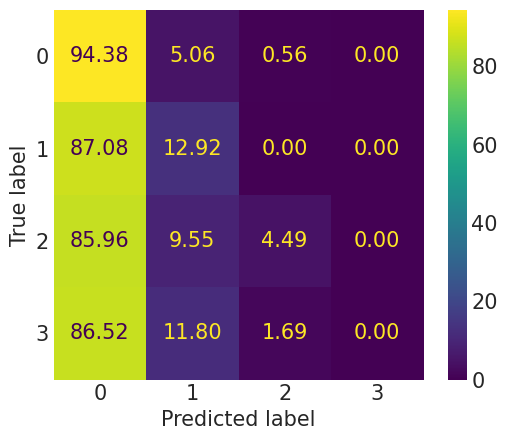

conf_id_114_model_2 test
0.2556179775280899


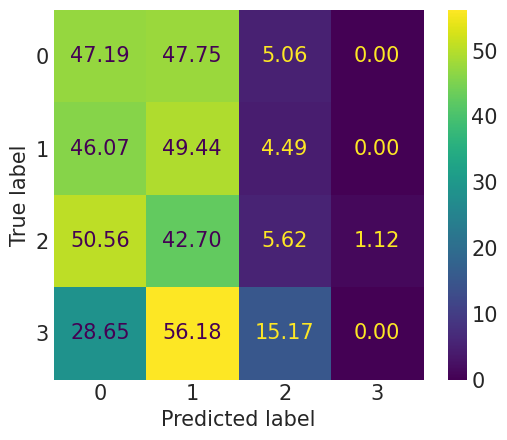

Average Confusion Matrix


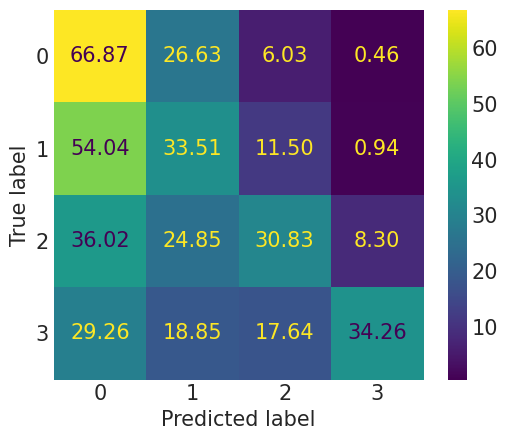

In [7]:
# supervised models
# plot all confusion matrices for knn classification for a conf_id
for cur_id in sl.index:
    cur_conf = models_conf.loc[cur_id]
    cur_models = models_doc.loc[models_doc["conf_id"] == cur_id]
    con_mas = np.zeros((4,4))

    use_sets = ["val", "test"]
    german = False
    save_plot = True
    counter = 0
    
    if german:
        lan_txt = "_ger"
    else:
        lan_txt = "_en"

    # n-back data
    blocks, chunks = prn.arange_data(lowpass=cur_conf["filter"], trans_band_auto=False, verbose=False)
    train_chunks, test_chunks = prn.get_train_test_sets(chunks, test_session=cur_conf["test_session"])
    folds = pr.get_folds(train_chunks, k_folds=10)

    for s in use_sets:
        for i, cur_mo in cur_models.iterrows():
            cur_conf = models_conf.loc[cur_mo["conf_id"]]
            print(cur_mo["model_name"], s)
            test_model = model.load_model(cur_mo["model_name"] + "_best_val", cur_conf["out_dim"], dropout_p=cur_conf["dropout_p"])
            
            if s == "test":
                train_set = train_chunks
                val_set = test_chunks
                file_name = os.path.join(plot.conf_matrix_path, "supervised", f"{cur_conf['filter']}hz", f"confusion_matrix_test_conf_id_{cur_id}_model_{cur_mo['val_idx']+1}_sl_test_ses_{int(cur_conf['test_session'])}{lan_txt}.png")
            elif s == "val":
                train_set, val_set = pr.get_train_val_sets(folds, cur_mo["val_idx"])
                file_name = os.path.join(plot.conf_matrix_path, "supervised", f"{cur_conf['filter']}hz", f"confusion_matrix_val_conf_id_{cur_id}_model_{cur_mo['val_idx']+1}_sl{lan_txt}.png")

            pred, acc = prd.make_predictions(val_set, train_set, test_model, k=7, blocks=blocks, distance_type="euclidean", device="cpu")
            print(acc)
            cm, disp = plot.plot_conf_matrix(pred, german=german)
            if save_plot:
                plt.savefig(file_name, dpi=200, bbox_inches="tight")
            plt.show()
            con_mas += cm
            counter += 1

        # average confusion matrix
        print("Average Confusion Matrix")
        plot.plot_conf_matrix(cm=con_mas/counter, german=german)

        if save_plot:
            if s == "test":
                plt.savefig(os.path.join(plot.conf_matrix_path, "supervised", f"{cur_conf['filter']}hz", f"confusion_matrix_test_conf_id_{cur_id}_sl_test_ses_{int(cur_conf['test_session'])}{lan_txt}.png"), dpi=200, bbox_inches="tight")
            elif s == "val":
                plt.savefig(os.path.join(plot.conf_matrix_path, "supervised", f"{cur_conf['filter']}hz", f"confusion_matrix_val_conf_id_{cur_id}_sl{lan_txt}.png"), dpi=200, bbox_inches="tight")
        plt.show()

c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible 

conf_id_111_model_1_ssl
0.25140449438202245


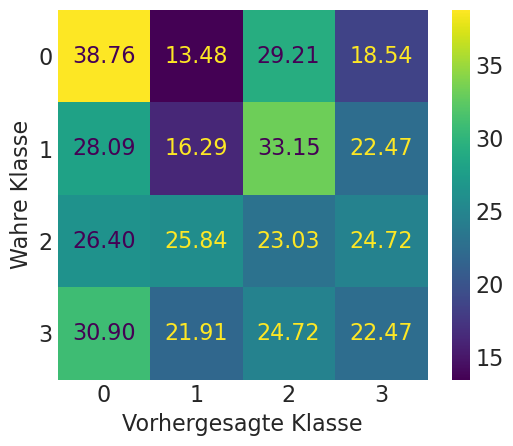

0.21207865168539325


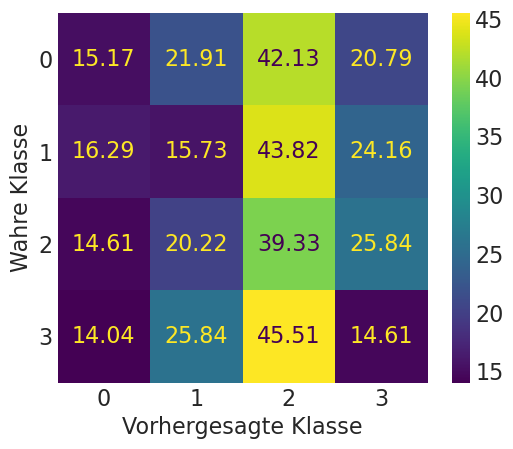

0.22752808988764045


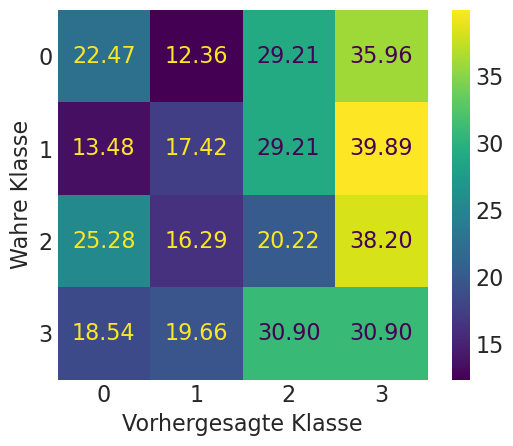

0.2148876404494382


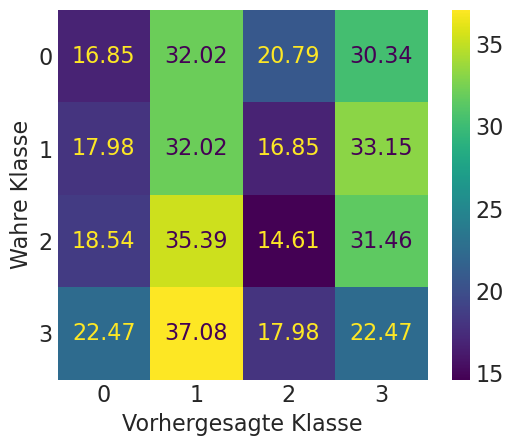

conf_id_111_model_3_ssl
0.2443820224719101


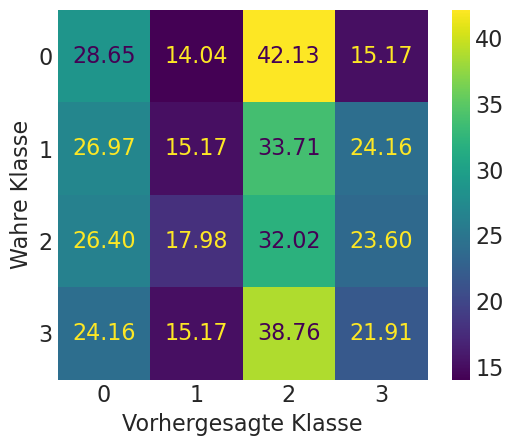

0.25


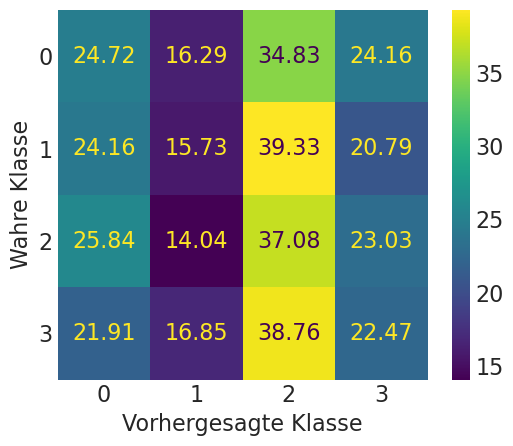

0.2148876404494382


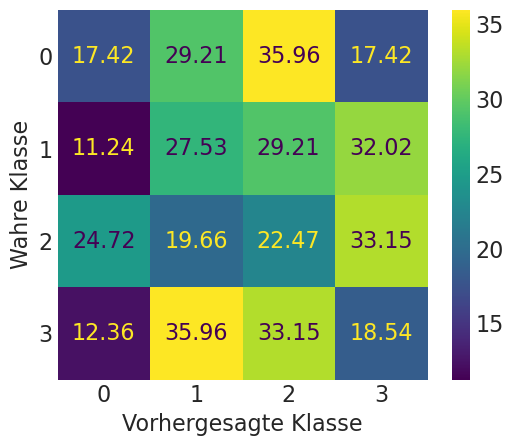

0.22612359550561797


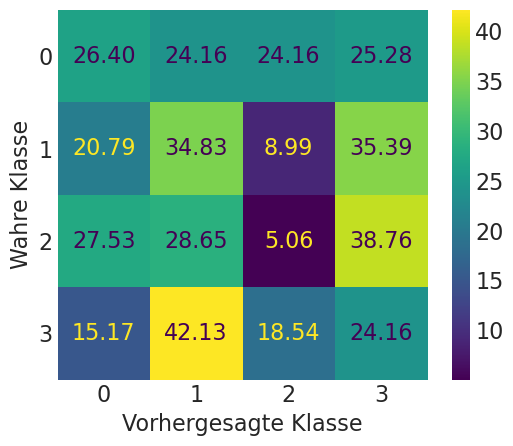

Average Confusion Matrix


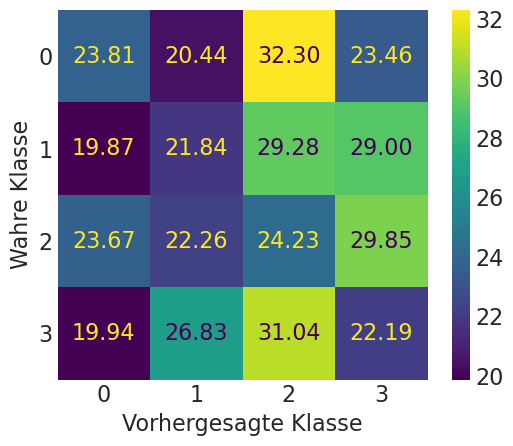

c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible 

conf_id_112_model_1_ssl
0.2640449438202247


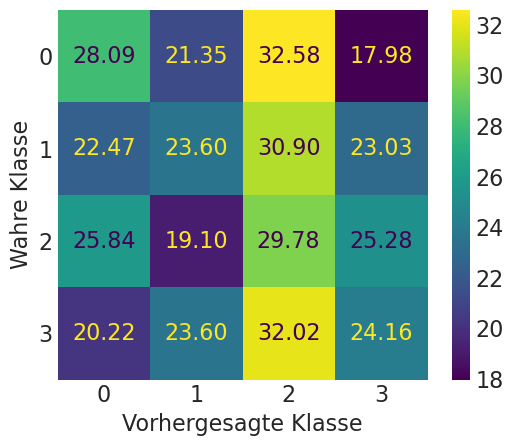

0.25280898876404495


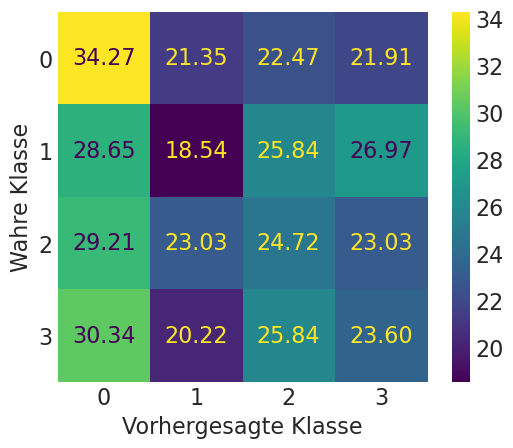

0.24719101123595505


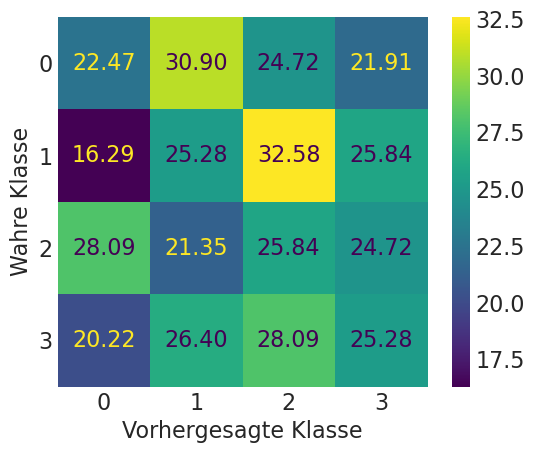

0.22191011235955055


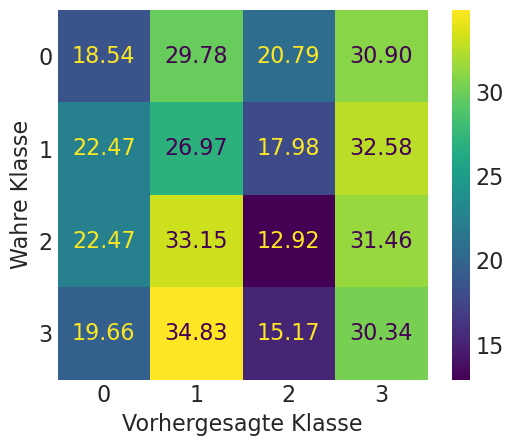

conf_id_112_model_3_ssl
0.2654494382022472


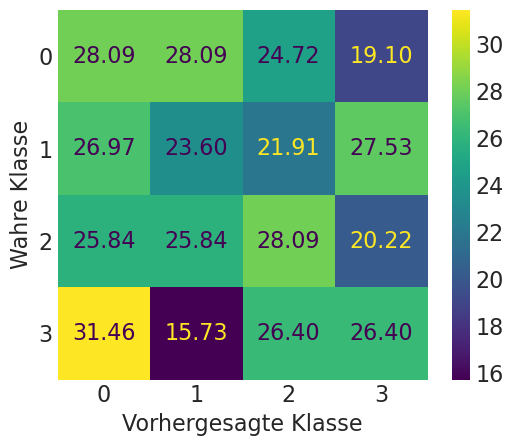

0.23314606741573032


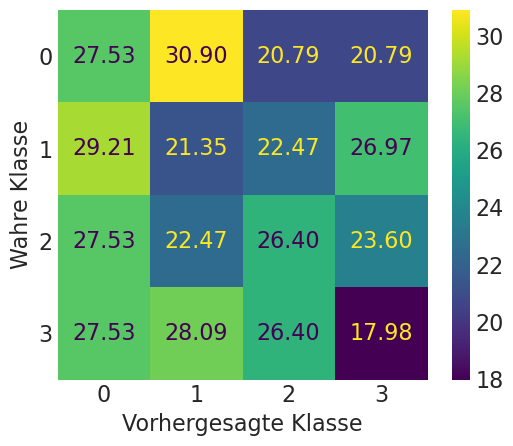

0.23174157303370788


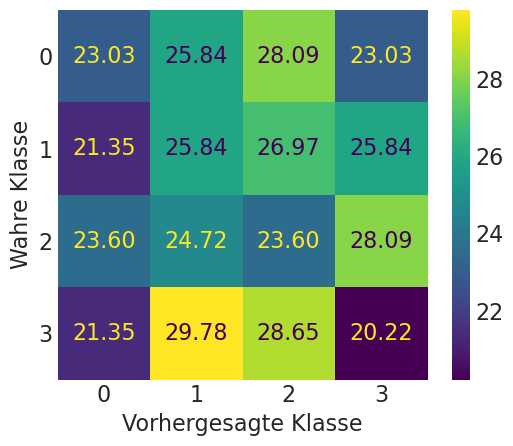

0.21910112359550563


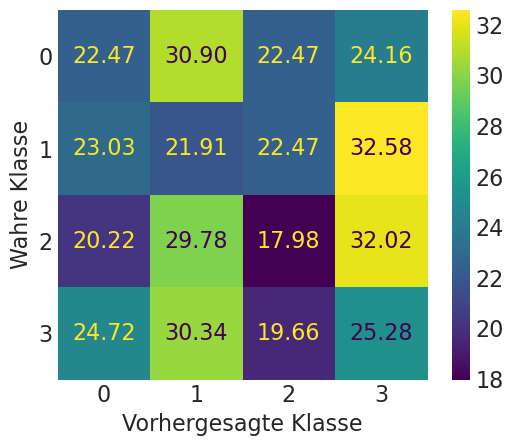

Average Confusion Matrix


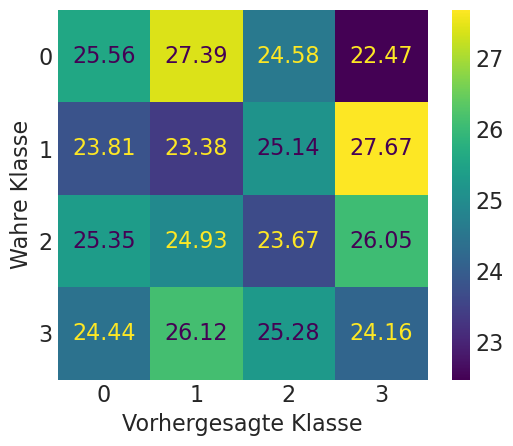

c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible 

conf_id_113_model_1_ssl
0.2542134831460674


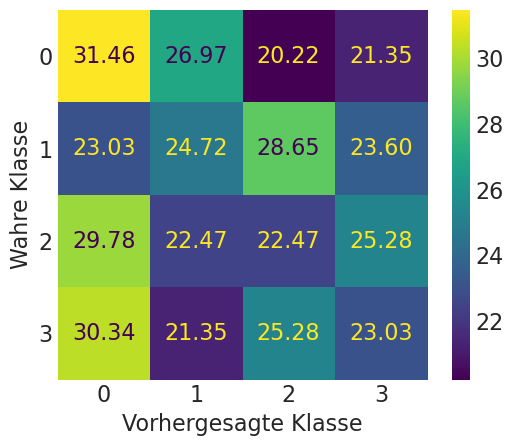

0.26685393258426965


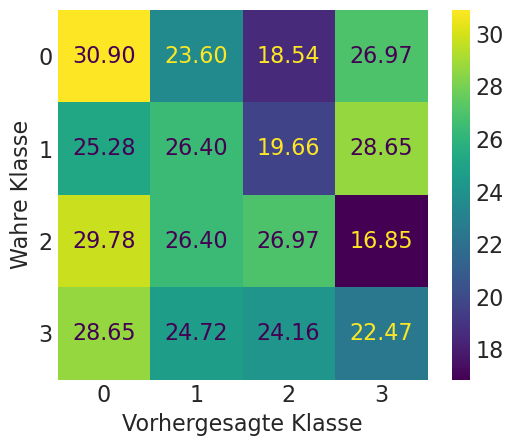

0.24157303370786518


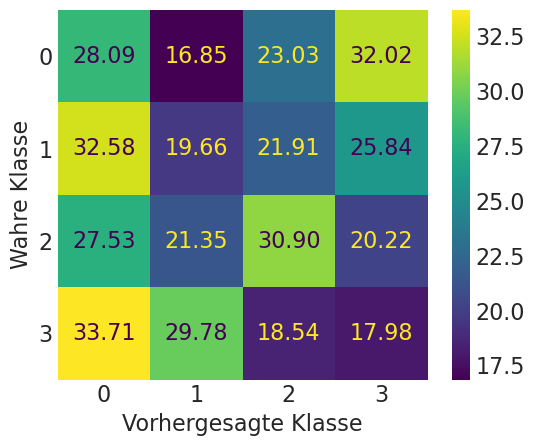

0.2598314606741573


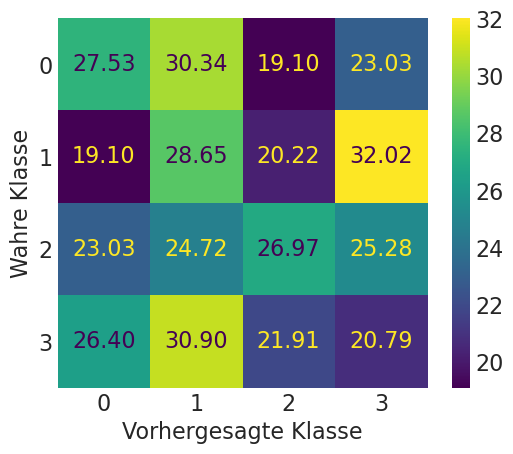

conf_id_113_model_3_ssl
0.24157303370786518


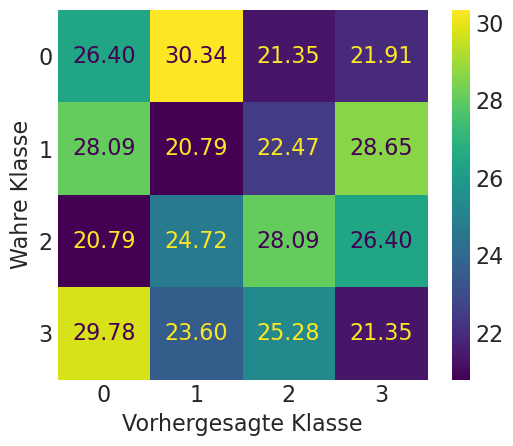

0.24859550561797752


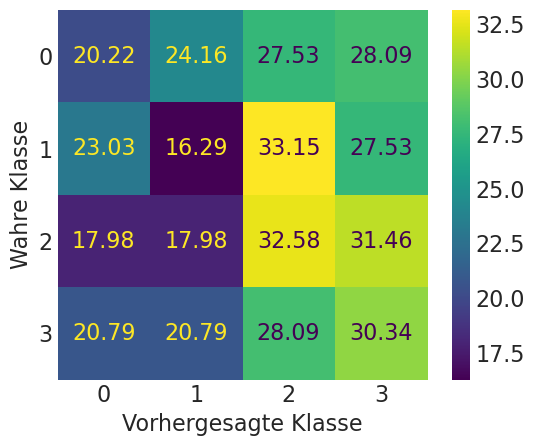

0.20786516853932585


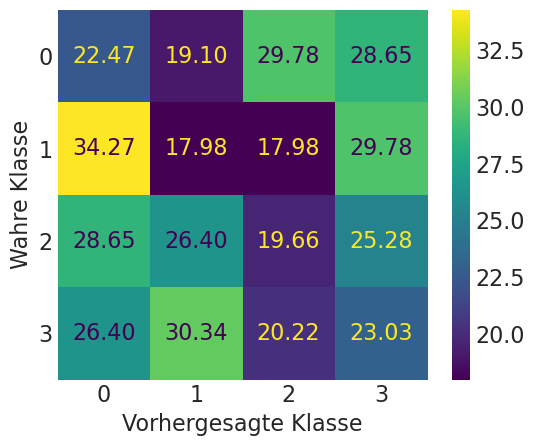

0.22612359550561797


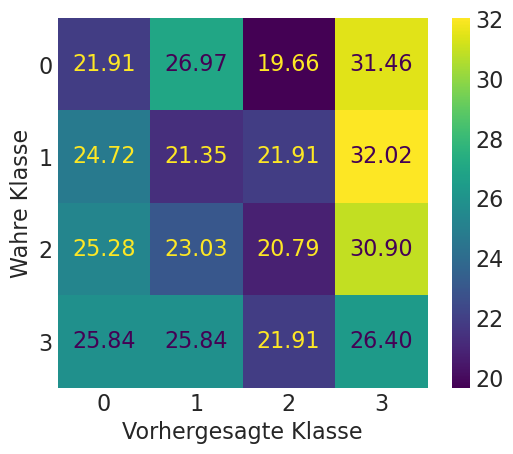

Average Confusion Matrix


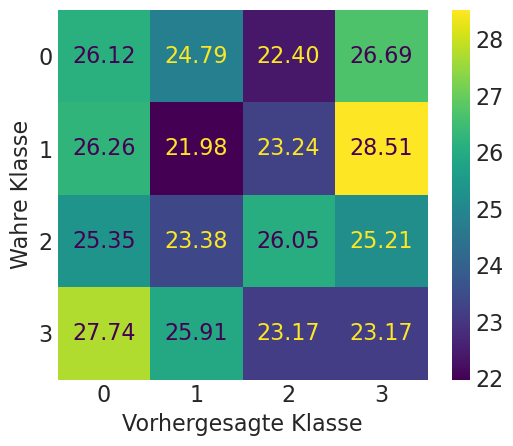

c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible 

conf_id_128_model_1_ssl
0.26264044943820225


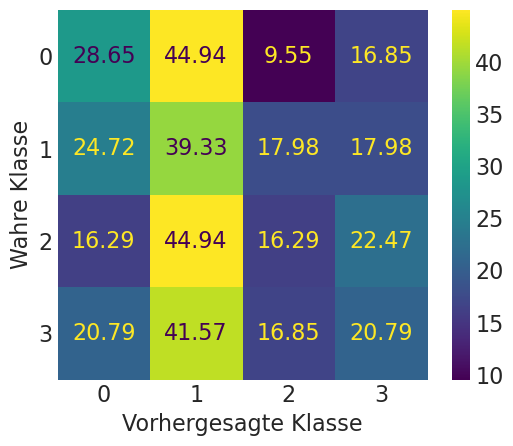

0.25140449438202245


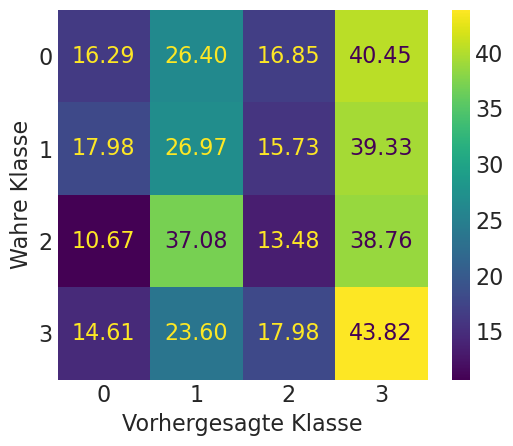

0.2401685393258427


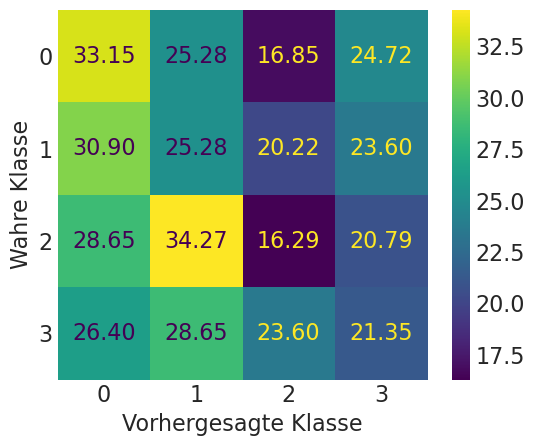

0.2443820224719101


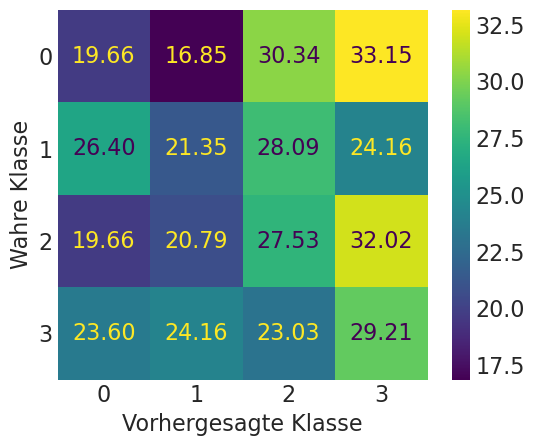

conf_id_128_model_3_ssl
0.23314606741573032


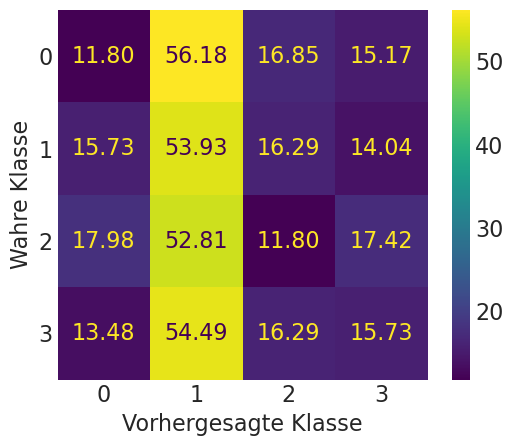

0.2851123595505618


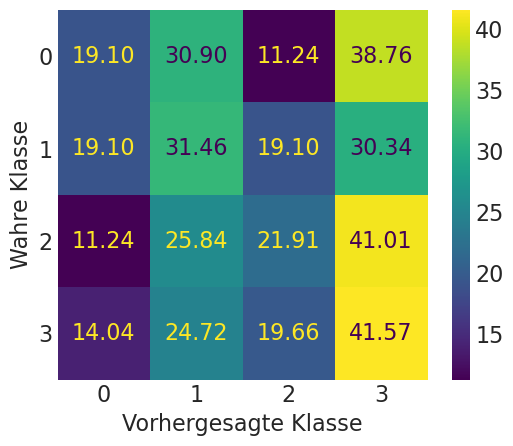

0.26264044943820225


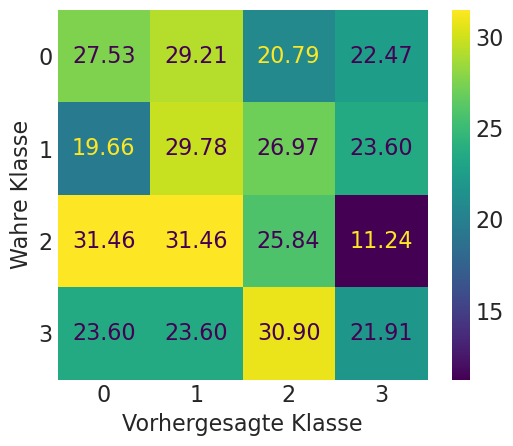

0.24859550561797752


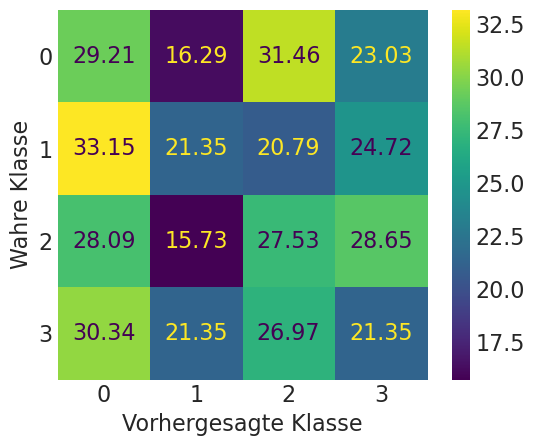

Average Confusion Matrix


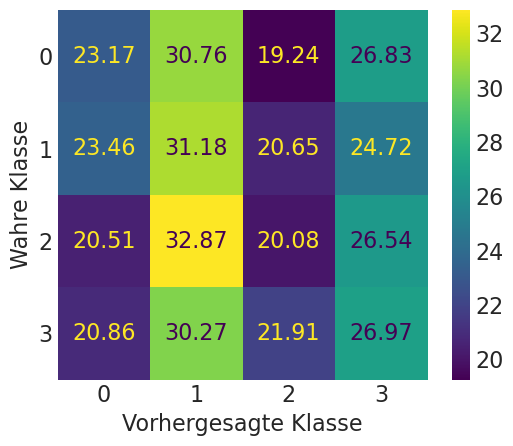

c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible 

conf_id_129_model_1_ssl
0.21067415730337077


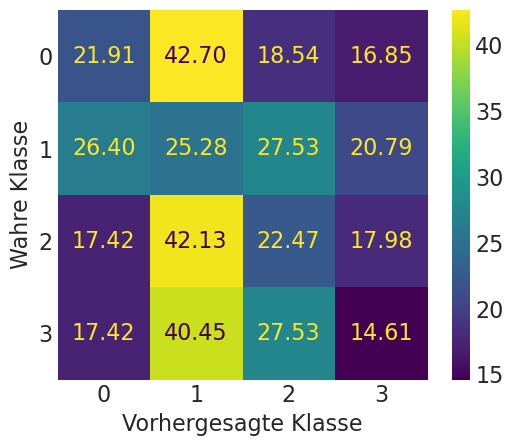

0.24297752808988765


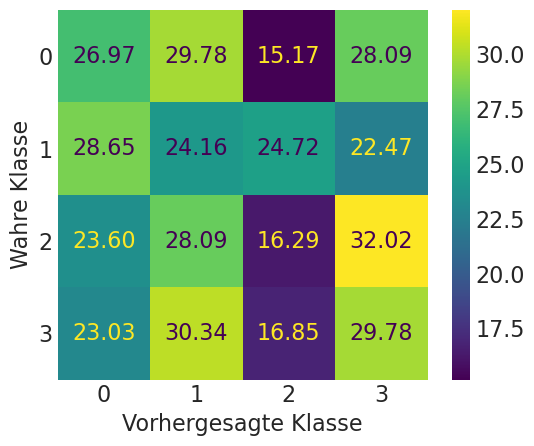

0.21207865168539325


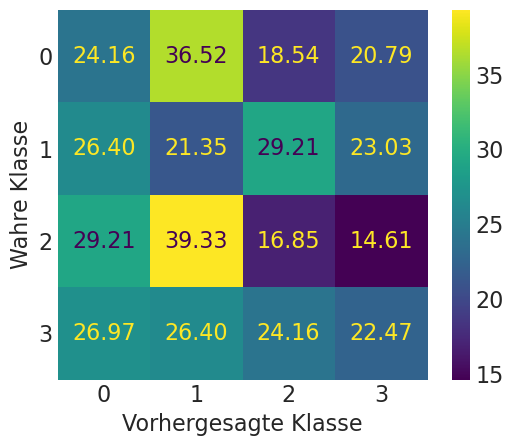

0.2247191011235955


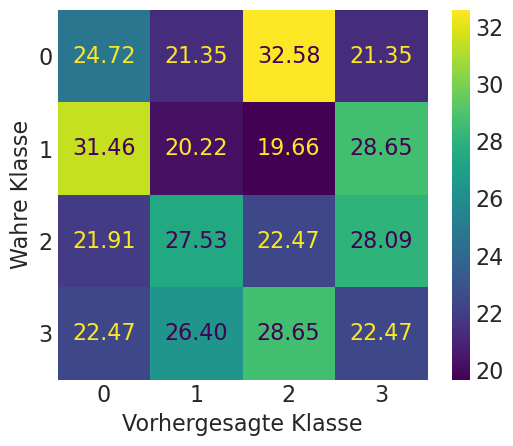

conf_id_129_model_3_ssl
0.26825842696629215


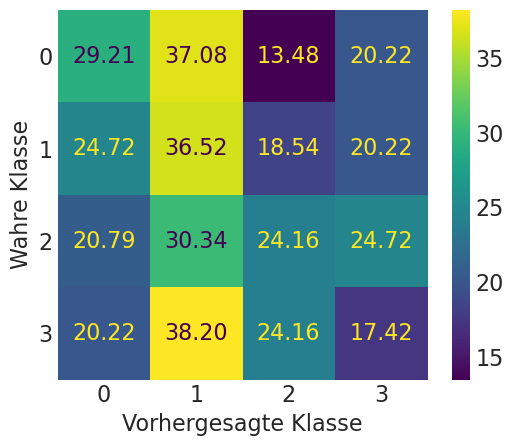

0.2654494382022472


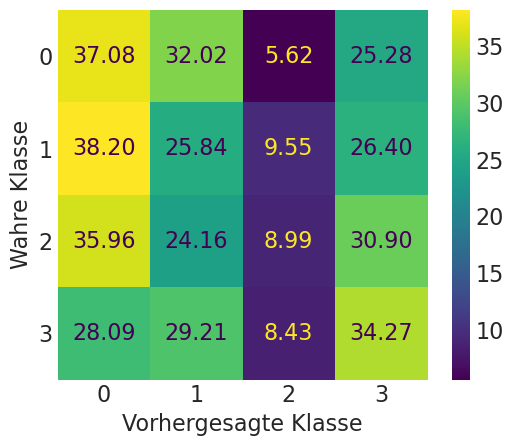

0.29634831460674155


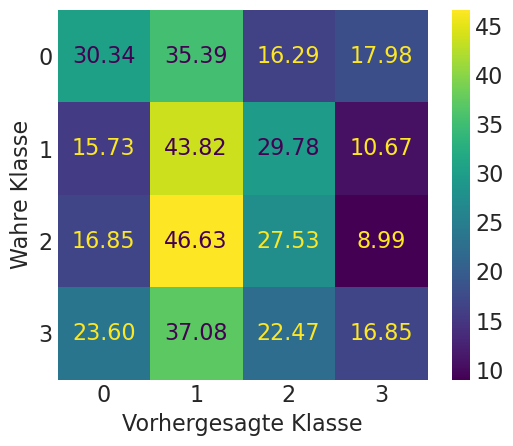

0.2345505617977528


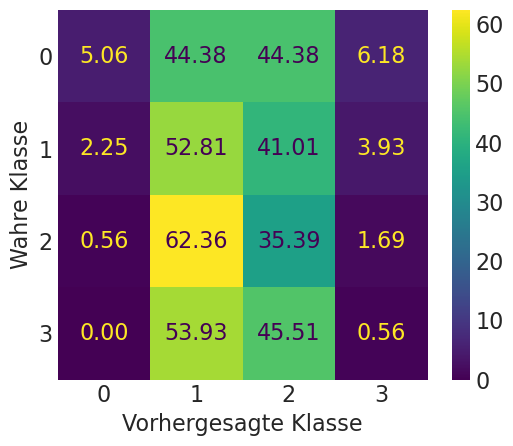

Average Confusion Matrix


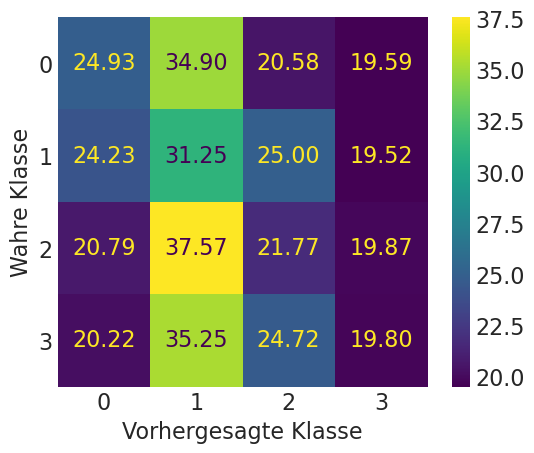

c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[eeg_df["time_stamp"] >= mark["time_stamp"], ["n_back_marker", "n"]] = [mark["marker"], n]
c:\Users\jeusa\Documents\Git\ssl-eeg\code\ssl_eeg\preprocessing_nback.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible 

conf_id_130_model_1_ssl
0.2401685393258427


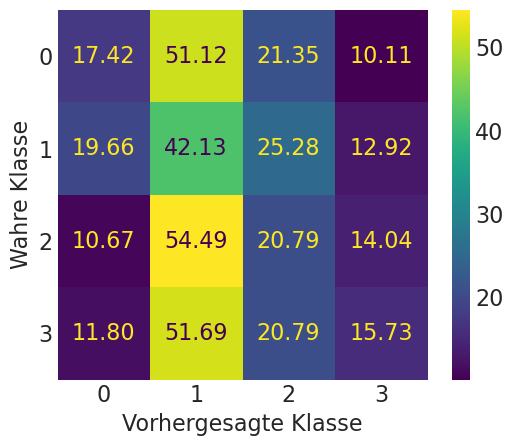

0.2612359550561798


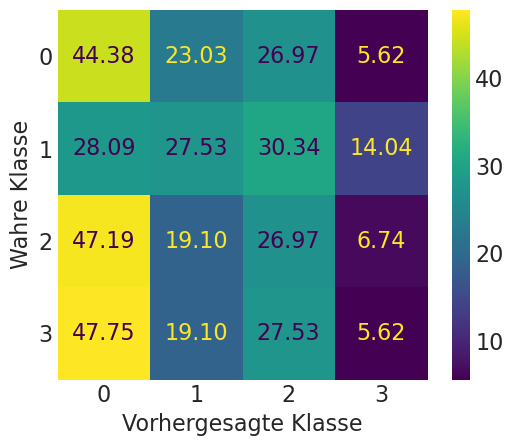

0.1544943820224719


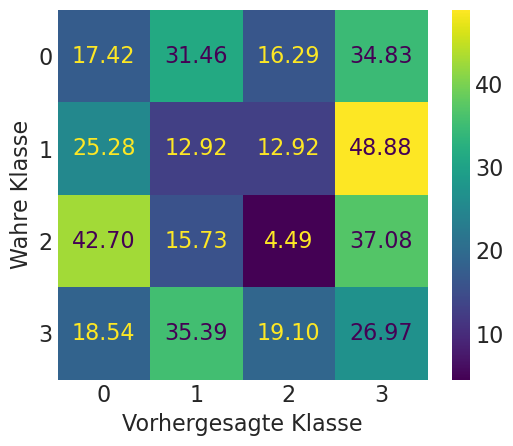

0.19241573033707865


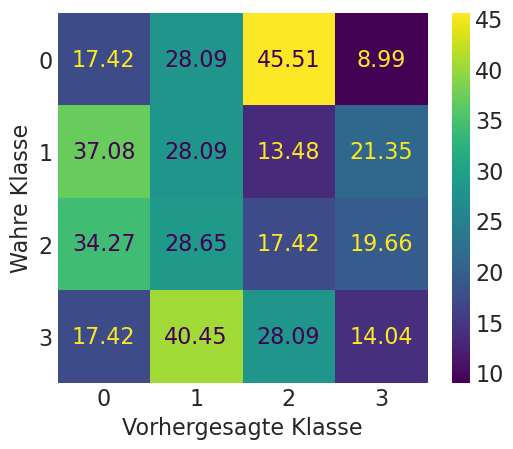

conf_id_130_model_3_ssl
0.25842696629213485


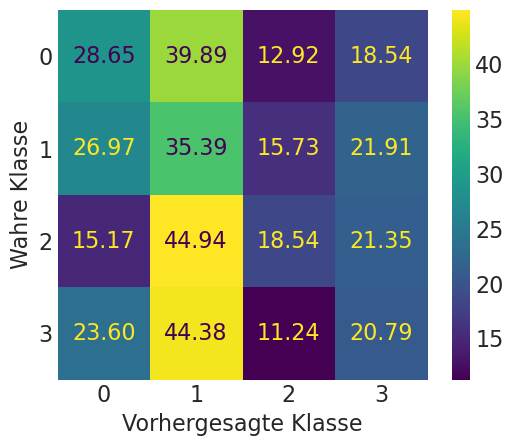

0.2640449438202247


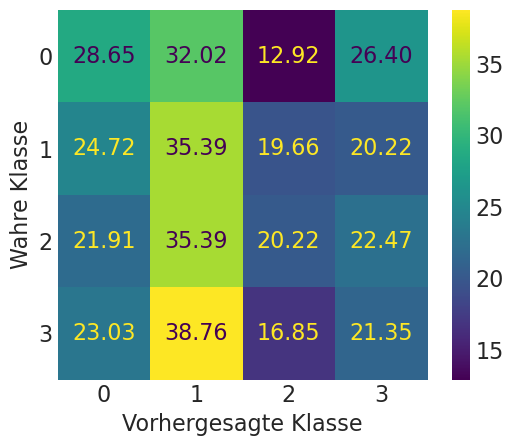

0.21629213483146068


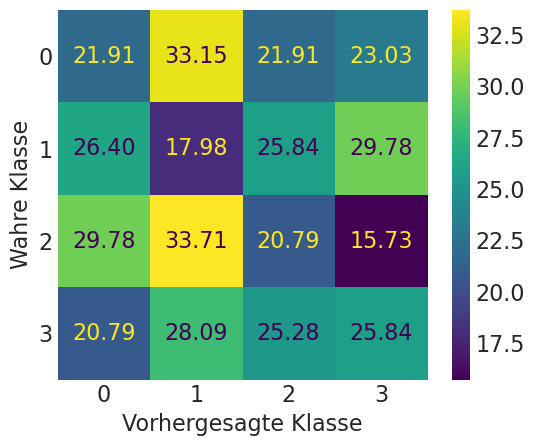

0.2696629213483146


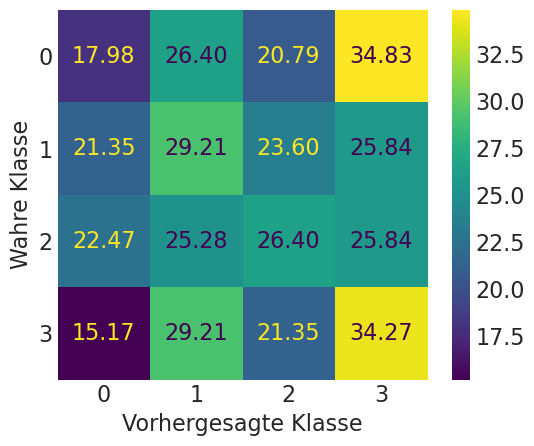

Average Confusion Matrix


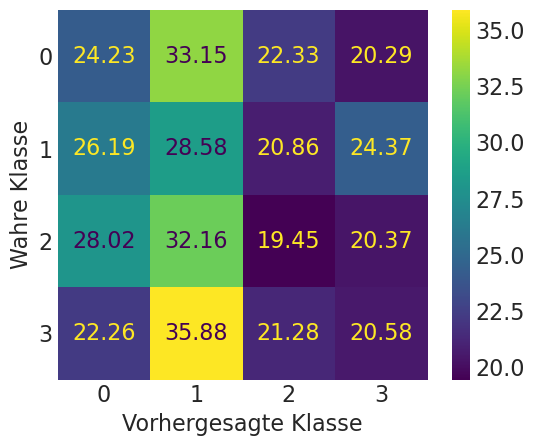

In [12]:
# self-supervised models
# plot all confusion matrices for knn classifikation
for cur_id in ssl.index:
    cur_conf = models_conf.loc[cur_id]
    cur_models = models_doc.loc[models_doc["conf_id"] == cur_id]
    con_mas = np.zeros((4,4))

    save_session_plots = True
    save_plot = True
    counter = 0

    # n-back data
    blocks, chunks = prn.arange_data(lowpass=cur_conf["filter"], trans_band_auto=False, verbose=False)
    folds = pr.get_folds(chunks, k_folds=5)

    for i, cur_mo in cur_models.iterrows():
        cur_conf = models_conf.loc[cur_mo["conf_id"]]
        print(cur_mo["model_name"])
        test_model = model.load_model(cur_mo["model_name"], cur_conf["out_dim"], dropout_p=cur_conf["dropout_p"])

        for t_s in range(4):
            train_chunks, test_chunks = prn.get_train_test_sets(chunks, test_session=t_s+1)
            pred, acc = prd.make_predictions(test_chunks, train_chunks, test_model, k=7, blocks=blocks, 
            distance_type="euclidean")
            print(acc)
            cm, disp = plot.plot_conf_matrix(pred)
            if save_session_plots:
                plt.savefig(os.path.join(plot.conf_matrix_path, "self-supervised", f"{cur_conf['filter']}hz", f"confusion_matrix_disjoint_session_{t_s+1}_conf_id_{cur_id}_ssl_augmentation_{int(cur_conf['augmentation_scale'])}_ger.png"), dpi=200, bbox_inches="tight")
            
            plt.show()
            con_mas += cm
            counter += 1

    # average confusion matrix
    print("Average Confusion Matrix")
    plot.plot_conf_matrix(cm=con_mas/counter)

    if save_plot:
        plt.savefig(os.path.join(plot.conf_matrix_path, "self-supervised", f"{cur_conf['filter']}hz", f"confusion_matrix_disjoint_conf_id_{cur_id}_ssl_augmentation_{int(cur_conf['augmentation_scale'])}_ger.png"), dpi=200, bbox_inches="tight")
    plt.show()


### Dimension Reduction

conf_id_118_model_1


/home/jeusa/Documents/Git/ssl-eeg/code/ssl_eeg/plot.py:129: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.scatterplot(x=red_data[:,0], y=red_data[:,1], hue=hue_data, s=size, palette=palette, hue_order=hue_order)


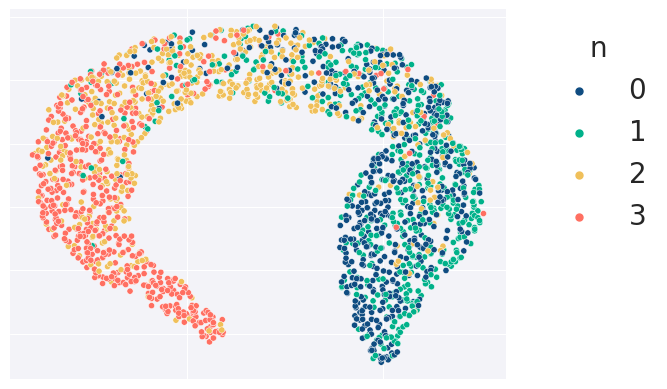

/home/jeusa/Documents/Git/ssl-eeg/code/ssl_eeg/plot.py:129: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.scatterplot(x=red_data[:,0], y=red_data[:,1], hue=hue_data, s=size, palette=palette, hue_order=hue_order)


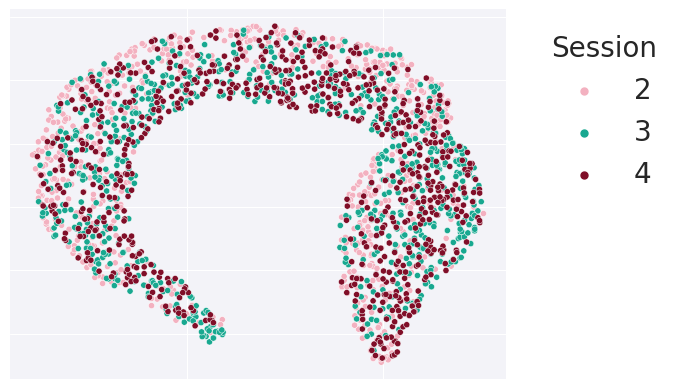

conf_id_118_model_2


/home/jeusa/Documents/Git/ssl-eeg/code/ssl_eeg/plot.py:129: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.scatterplot(x=red_data[:,0], y=red_data[:,1], hue=hue_data, s=size, palette=palette, hue_order=hue_order)


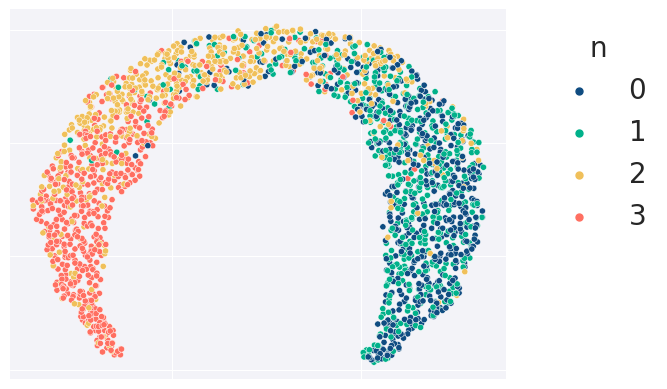

/home/jeusa/Documents/Git/ssl-eeg/code/ssl_eeg/plot.py:129: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.scatterplot(x=red_data[:,0], y=red_data[:,1], hue=hue_data, s=size, palette=palette, hue_order=hue_order)


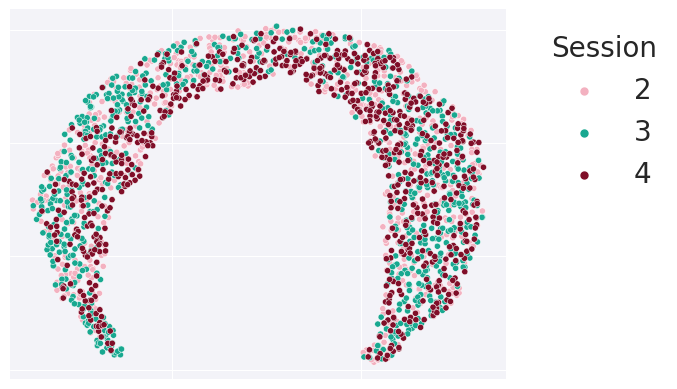

In [6]:
mpl.rcParams["font.size"] = 20
german = False
train_ses = True
test_ses = False
all_ses = False
ssl_ses = False

for i, cur_model in models_doc.iterrows():
    cur_conf = models_conf.loc[cur_model["conf_id"]]
    if cur_conf["relevant"] and cur_model["conf_id"] == 118:
        model_name = cur_model["model_name"]
        test_model = model.load_model(model_name, cur_conf["out_dim"], cur_conf["dropout_p"])
        print(model_name)

        # n-back data
        blocks, chunks = prn.arange_data(lowpass=cur_conf["filter"], trans_band_auto=False, verbose=False)
        train_chunks, test_chunks = prn.get_train_test_sets(chunks, test_session=cur_conf["test_session"])
        folds = pr.get_folds(train_chunks, k_folds=10)
        train_set, val_set = pr.get_train_val_sets(folds, cur_model["val_idx"])

        # unlabeled data
        if cur_conf["supervised"] == "self-supervised":
            blocks_u_full, chunks_u = pru.arange_data(lowpass=cur_conf["filter"], trans_band_auto=False, verbose=False)
            blocks_ut = torch.from_numpy(blocks_u_full.to_numpy()).T
            chunks_ut = torch.from_numpy(chunks_u.to_numpy())
            
            chunks_u_data = pru.get_samples_data(chunks_ut, blocks_ut)
            chunks_u_data = pru.get_samples_data(chunks_ut, blocks_ut)
            chunks_u_data = pr.normalize_data(chunks_u_data)
            chunks_u_loader = torch.utils.data.DataLoader(chunks_u_data, batch_size=1048, shuffle=False)
        
        # n-back output
        out, ns = prd.get_model_output_n(test_model, train_chunks, blocks, as_df=False)
        out_df = prd.get_model_output_n(test_model, train_chunks, blocks, as_df=True)
        out_train, ns_train = prd.get_model_output_n(test_model, train_set, blocks, as_df=False)
        out_train_df = prd.get_model_output_n(test_model, train_set, blocks, as_df=True)
        out_val, ns_val = prd.get_model_output_n(test_model, val_set, blocks, as_df=False)
        out_val_df = prd.get_model_output_n(test_model, val_set, blocks, as_df=True)
        out_test, ns_test = prd.get_model_output_n(test_model, test_chunks, blocks, as_df=False)
        out_test_df = prd.get_model_output_n(test_model, test_chunks, blocks, as_df=True)
        out_all, ns_all = prd.get_model_output_n(test_model, chunks, blocks, as_df=False)
        out_all_df = prd.get_model_output_n(test_model, chunks, blocks, as_df=True)

        if cur_conf["supervised"] == "self-supervised":
            # unlabeled output
            out_u = prd.get_model_output_loader(test_model, chunks_u_loader)
            # labeled and unlabeled
            out_l_u = torch.concat([out_u, out])

            unl_name = "ungelabelte Daten"
            nb_name = "n-back Daten"
            if not german:
                unl_name = "unlabeled data"
                nb_name = "n-back data"

            l_u = np.concatenate([np.repeat([unl_name], out_u.shape[0]), np.repeat([nb_name], out.shape[0])])
        
        # umaps
        path_prefix = os.path.join("dimension_reduction", cur_conf["supervised"], f"{cur_conf['filter']}hz")
        if cur_conf["supervised"] == "supervised":
            # training and validation data
            if train_ses:
                leg_title = "Aufnahme"
                if not german:
                    leg_title = "Session"
                data = out.cpu()
                n_data = ns.int()
                sessions = train_chunks["session_no"]
                file_name_n = f"dim_red_UMAP_{model_name}_sl_test_ses_{int(cur_conf['test_session'])}"
                file_name_ses = f"dim_red_train_sessions_UMAP_{model_name}_sl_test_ses_{int(cur_conf['test_session'])}"

                dim_red = metrics.dim_red_umap(data)
                n_ax = plot.plot_dim_red(dim_red, n_data, legend_title="n", palette=sns.color_palette())
                ses_ax = plot.plot_dim_red(dim_red, sessions, legend_title=leg_title, palette=plot.n_color_cycle)
                plot.save_plot_and_legend(n_ax, os.path.join(path_prefix, file_name_n))
                plot.save_plot_and_legend(ses_ax, os.path.join(path_prefix, file_name_ses))

            # test data
            if test_ses:
                data = out_test.cpu()
                n_data = ns_test.int()
                file_name = f"dim_red_test_UMAP_{model_name}_sl_test_ses_{int(cur_conf['test_session'])}"

                dim_red = metrics.dim_red_umap(data, neighbors=10, min_dist=1)
                test_n_ax = plot.plot_dim_red(dim_red, n_data, legend_title="n", palette=sns.color_palette())
                plot.save_plot_and_legend(test_n_ax, os.path.join(path_prefix, file_name))
            
            # all data
            if all_ses:
                test_name = "Testaufnahme"
                train_name = "Trainingsaufnahmen"
                if not german:
                    test_name = "test session"
                    train_name = "train session"

                data = out_all.cpu()
                chunks_a = chunks.copy()
                chunks_a.loc[chunks["session_no"]==cur_conf["test_session"], "n"] = test_name
                chunks_a["test"] = train_name
                chunks_a.loc[(chunks_a["n"] == test_name), "test"] = test_name

                tr = chunks_a.loc[chunks_a["test"]==train_name]
                ts = chunks_a.loc[chunks_a["test"]==test_name]
                data_tr = data[tr.index]
                data_ts = data[ts.index]
                chunks_a_sorted = pd.concat([tr, ts])
                data_sorted = torch.concat([data_tr, data_ts])

                file_name_n = f"dim_red_all_UMAP_{model_name}_sl_test_ses_{int(cur_conf['test_session'])}"
                file_name_ses = f"dim_red_all_sessions_UMAP_{model_name}_sl_test_ses_{int(cur_conf['test_session'])}"

                dim_red = metrics.dim_red_umap(data_sorted)
                all_n_ax = plot.plot_dim_red(dim_red, chunks_a_sorted["n"], legend_title="n", hue_order=[0,1,2,3,test_name], palette=sns.color_palette())
                all_ses_ax = plot.plot_dim_red(dim_red, chunks_a_sorted["test"], legend_title="", palette=sns.color_palette([plot.n_color_cycle[0], plot.n_color_cycle[2]]), hue_order=[train_name, test_name])
                plot.save_plot_and_legend(all_n_ax, os.path.join(path_prefix, file_name_n))
                plot.save_plot_and_legend(all_ses_ax, os.path.join(path_prefix, file_name_ses))
        
        if cur_conf["supervised"] == "self-supervised" and ssl_ses:
            # labeled and unlabeled data
            file_name = f"dim_red_UMAP_{model_name}"
            dim_red = metrics.dim_red_umap(out_l_u.cpu())
            ssl_ax = plot.plot_dim_red(dim_red, l_u, size=7, palette=[plot.u_main_color, plot.n_sec_color])
            plot.save_plot_and_legend(ssl_ax, os.path.join(path_prefix, file_name))